In [1]:
from mafaulda_metrics import *
from mafaulda_naive_bayes import *
from mafaulda_preprocessing import *

In [2]:
# ========================
# --- data importation ---
# ========================

CSV_FILE = 'data/mafaulda_main_classes_24khz_500ms_20ms_40-mfcc.csv'

FEATURES = [
    'mfcc_1',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8'
]

df = data_reading(
    csv_file = CSV_FILE,
    features_columns = FEATURES
)

In [3]:
# ========================
# --- data preparation ---
# ========================

N_SAMPLES       = 6000
RANDOM_STATE    = 42

sampling_strategy = {i: N_SAMPLES for i in range(6)}

df = data_preparation(
    df                  = data_cleaning(df),
    columns_to_drop     = ['filename', 'class', 'label', 'source'],
    sampling_strategy   = sampling_strategy,
    scaling_method      = 'RobustScaler',
    random_state        = RANDOM_STATE
)

In [4]:
import cuml
from xgboost import DMatrix

X_train, y_train, X_test, y_test = data_splitting(
    df              = df,
    test_size       = 0.2,
    random_state    = RANDOM_STATE
)

# Convert the datasets into DMatrix
dtrain  = DMatrix(X_train, label=y_train)
dtest   = DMatrix(X_test, label=y_test)

# initialize the StratifiedKFold with 5 folds
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# list to store the accuracies of each fold
accuracies = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)

    # Criar e treinar o modelo
    # model = MultinomialNB()
    # model = GaussianNB()
    model = cuml.naive_bayes.BernoulliNB()
    model.fit(X_train_fold, y_train_fold)

    # Fazer previsões e avaliar o modelo
    y_pred = model.predict(X_test_fold)

    # Converter y_test_fold para numpy array para a comparação
    accuracy = cuml.metrics.accuracy_score(y_test_fold, y_pred)
    accuracies.append(accuracy)

# Exibir as acurácias dos folds e a média
print('Accuracies for each fold:')
for i, acc in enumerate(accuracies, start=1):
    print(f'Fold {i}: {acc:.4f}')
print(f'Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

AttributeError: module 'cuml.metrics' has no attribute 'fbeta_score'

Accuracies for each fold:
Fold 1: 0.3692
Fold 2: 0.3738
Fold 3: 0.3679
Fold 4: 0.3744
Fold 5: 0.3718
Mean Accuracy: 0.3714 ± 0.0025


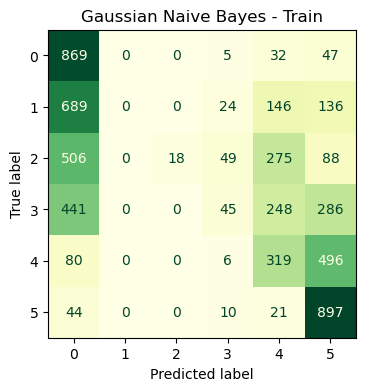

In [7]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import metrics, model_selection
import numpy as np

X_train, y_train, X_test, y_test = data_splitting(
    df              = df,
    test_size       = 0.2,
    random_state    = RANDOM_STATE
)

# Inicializar o StratifiedKFold com 5 folds
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lista para armazenar as acurácias de cada fold
accuracies = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Criar e treinar o modelo
    # model = BernoulliNB()
    model = GaussianNB()
    model.fit(X_train_fold, y_train_fold)

    # Fazer previsões e avaliar o modelo
    y_pred = model.predict(X_test_fold)

    # Converter y_test_fold para numpy array para a comparação
    accuracy = metrics.accuracy_score(y_test_fold, y_pred)
    accuracies.append(accuracy)

# Calcular a média e o desvio padrão das acurácias
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Exibir as acurácias dos folds e a média
print('Accuracies for each fold:')
for i, acc in enumerate(accuracies, start=1):
    print(f'Fold {i}: {acc:.4f}')
print(f'Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_fold, y_pred)
class_names = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="YlGn", ax=ax, colorbar=False)
# ax.set_title(f"Gaussian Naive Bayes")
ax.set_title(f"Gaussian Naive Bayes - Train")
# plt.savefig(f"results/mafaulda_main_classes_gaussian_naive_bayes_confusion-matrix.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

In [ ]:
from cuml.svm import LinearSVC

accuracies = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)

    # Criar e treinar o modelo
    svm_args = {
        'C': 0.01,
        'gamma': 'scale'
    }
    model = LinearSVC(**svm_args)
    model.fit(X_train_fold, y_train_fold)

    # Fazer previsões e avaliar o modelo
    y_pred = model.predict(X_test_fold)

    # Converter y_test_fold para numpy array para a comparação
    accuracy = metrics.accuracy_score(y_test_fold, y_pred)
    accuracies.append(accuracy)


# Show folds accuracies and a mean accuracy
print('Accuracies for each fold:')
for i, acc in enumerate(accuracies, start=1):
    print(f'Fold {i}: {acc:.4f}')
print()
print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_fold, y_pred)
class_names = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="YlGn", ax=ax, colorbar=False)
# ax.set_title(f"SVM {svm_args['kernel']}({svm_args['degree']} degrees), C={svm_args['C']}")
ax.set_title(f"SVM {svm_args['kernel']}, C={svm_args['C']}")
# plt.savefig(f"results/mafaulda_main_classes_time_features_only_svm_kernel={svm_args['kernel']}_degree={svm_args['degree']}_C={svm_args['C']}_confusion-matrix.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

Accuracies for each fold:
Fold 1: 0.8044
Fold 2: 0.8025
Fold 3: 0.8036
Fold 4: 0.8070
Fold 5: 0.8054

Mean Accuracy: 0.8046 ± 0.0015


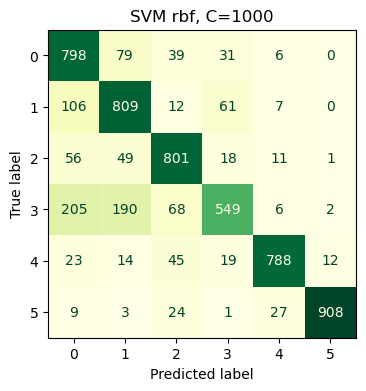

In [8]:
from cuml.svm import SVC, LinearSVC

accuracies = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)

    # Criar e treinar o modelo
    svm_args = {
        'kernel': 'rbf', # 'linear', 'poly', 'rbf'
        # 'degree':  3,
        'C': 1000,
        'gamma': 'scale'
    }
    # model = LinearSVC(**svm_args)
    model = SVC(**svm_args)
    model.fit(X_train_fold, y_train_fold)

    # Fazer previsões e avaliar o modelo
    y_pred = model.predict(X_test_fold)

    # Converter y_test_fold para numpy array para a comparação
    accuracy = metrics.accuracy_score(y_test_fold, y_pred)
    accuracies.append(accuracy)


# Show folds accuracies and a mean accuracy
print('Accuracies for each fold:')
for i, acc in enumerate(accuracies, start=1):
    print(f'Fold {i}: {acc:.4f}')
print()
print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_fold, y_pred)
class_names = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="YlGn", ax=ax, colorbar=False)
# ax.set_title(f"SVM {svm_args['kernel']}({svm_args['degree']} degrees), C={svm_args['C']}")
ax.set_title(f"SVM {svm_args['kernel']}, C={svm_args['C']}")
# plt.savefig(f"results/mafaulda_main_classes_time_features_only_svm_kernel={svm_args['kernel']}_degree={svm_args['degree']}_C={svm_args['C']}_confusion-matrix.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

Test Accuracy: 0.7975


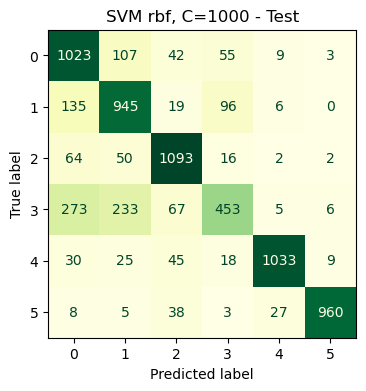

In [10]:
# Testing the best model with the test dataset
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
class_names = ["0", "1", "2", "3", "4", "5"]
fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="YlGn", ax=ax, colorbar=False)
# ax.set_title(f"SVM {svm_args['kernel']}({svm_args['degree']} degrees), C={svm_args['C']}")
ax.set_title(f"SVM {svm_args['kernel']}, C={svm_args['C']} - Test")
# plt.savefig(f"results/mafaulda_main_classes_time_features_only_svm_kernel={svm_args['kernel']}_degree={svm_args['degree']}_C={svm_args['C']}_confusion-matrix.pdf", format="pdf", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

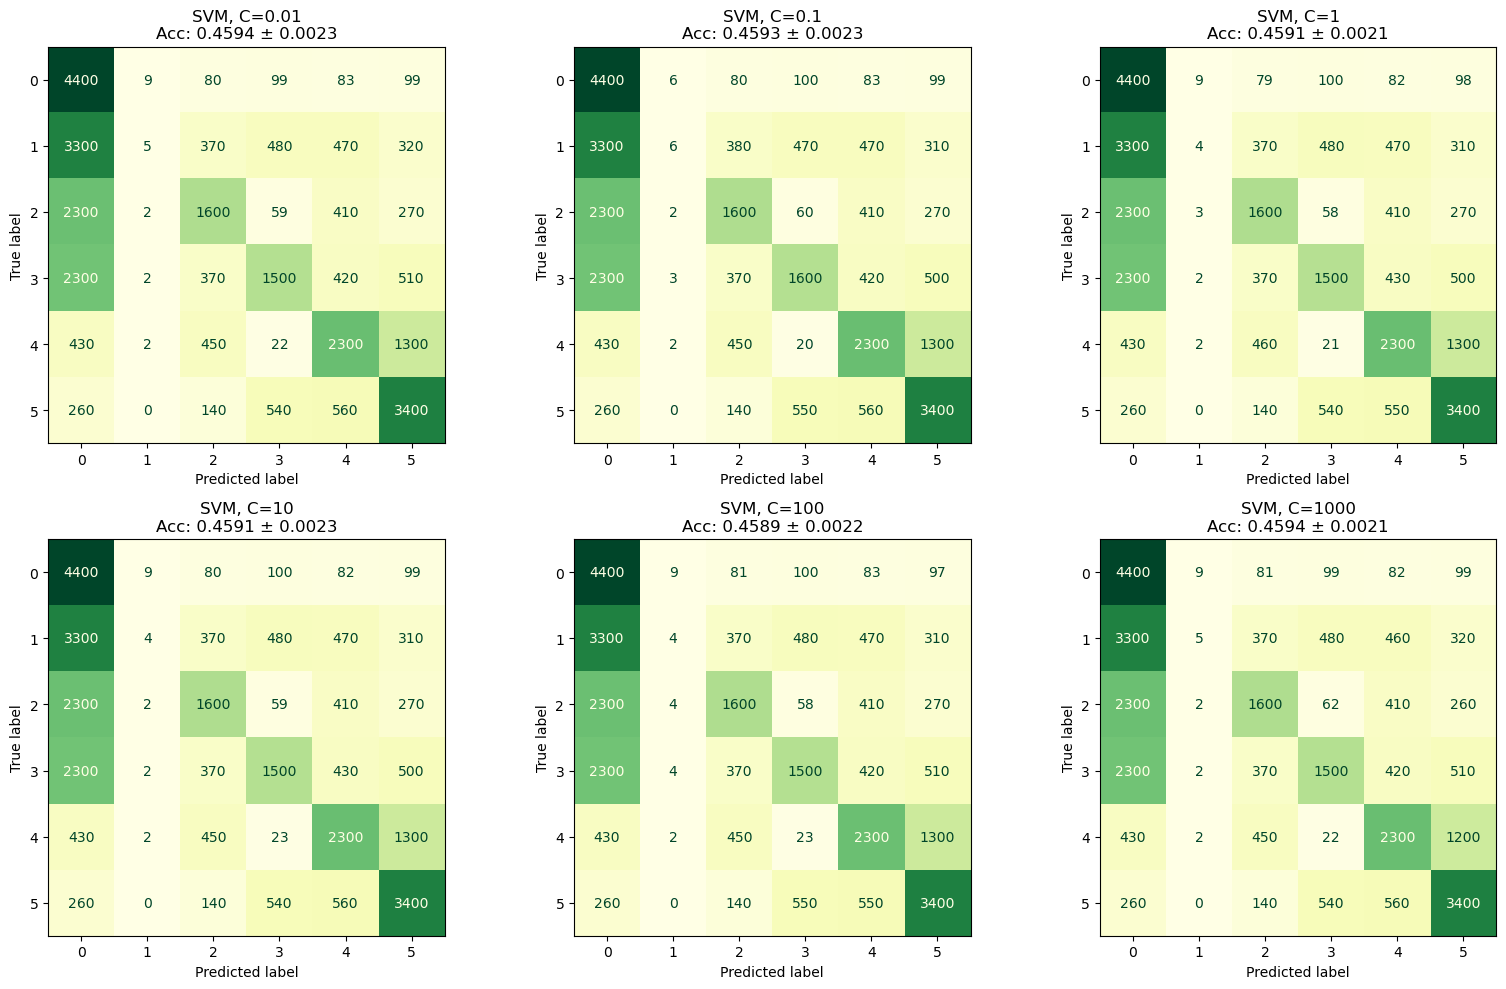

In [15]:
from cuml.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Valores de C a serem testados
C_values = [0.01, 0.1, 1, 10, 100, 1000]

# Configuração do Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plotar as matrizes de confusão em subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # Aumentei o tamanho da figura para 16x10
axes = axes.ravel()

for i, C in enumerate(C_values):
    accuracies = []
    cm_total = np.zeros((6, 6))  # Assumindo 6 classes para combinar as matrizes de confusão

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Criar e treinar o modelo
        model = LinearSVC(C=C)
        model.fit(X_train_fold, y_train_fold)

        # Fazer previsões e avaliar o modelo
        y_pred = model.predict(X_test_fold)
        accuracy = metrics.accuracy_score(y_test_fold, y_pred)
        accuracies.append(accuracy)

        # Atualizar a matriz de confusão acumulada
        cm = metrics.confusion_matrix(y_test_fold, y_pred, labels=[0, 1, 2, 3, 4, 5])
        cm_total += cm

    # Plotar a matriz de confusão acumulada para o valor de C atual
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=["0", "1", "2", "3", "4", "5"])
    disp.plot(cmap="YlGn", ax=axes[i], colorbar=False)

    # Garantir que os números sejam mostrados inteiros (sem notação científica)
    for labels in disp.text_.ravel():
        labels.set_text(f'{int(float(labels.get_text()))}')  # Converter o texto para inteiro

    axes[i].set_title(f"SVM, C={C}\nAcc: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

# Ajustes finais e exibição do gráfico
plt.tight_layout()
plt.show()


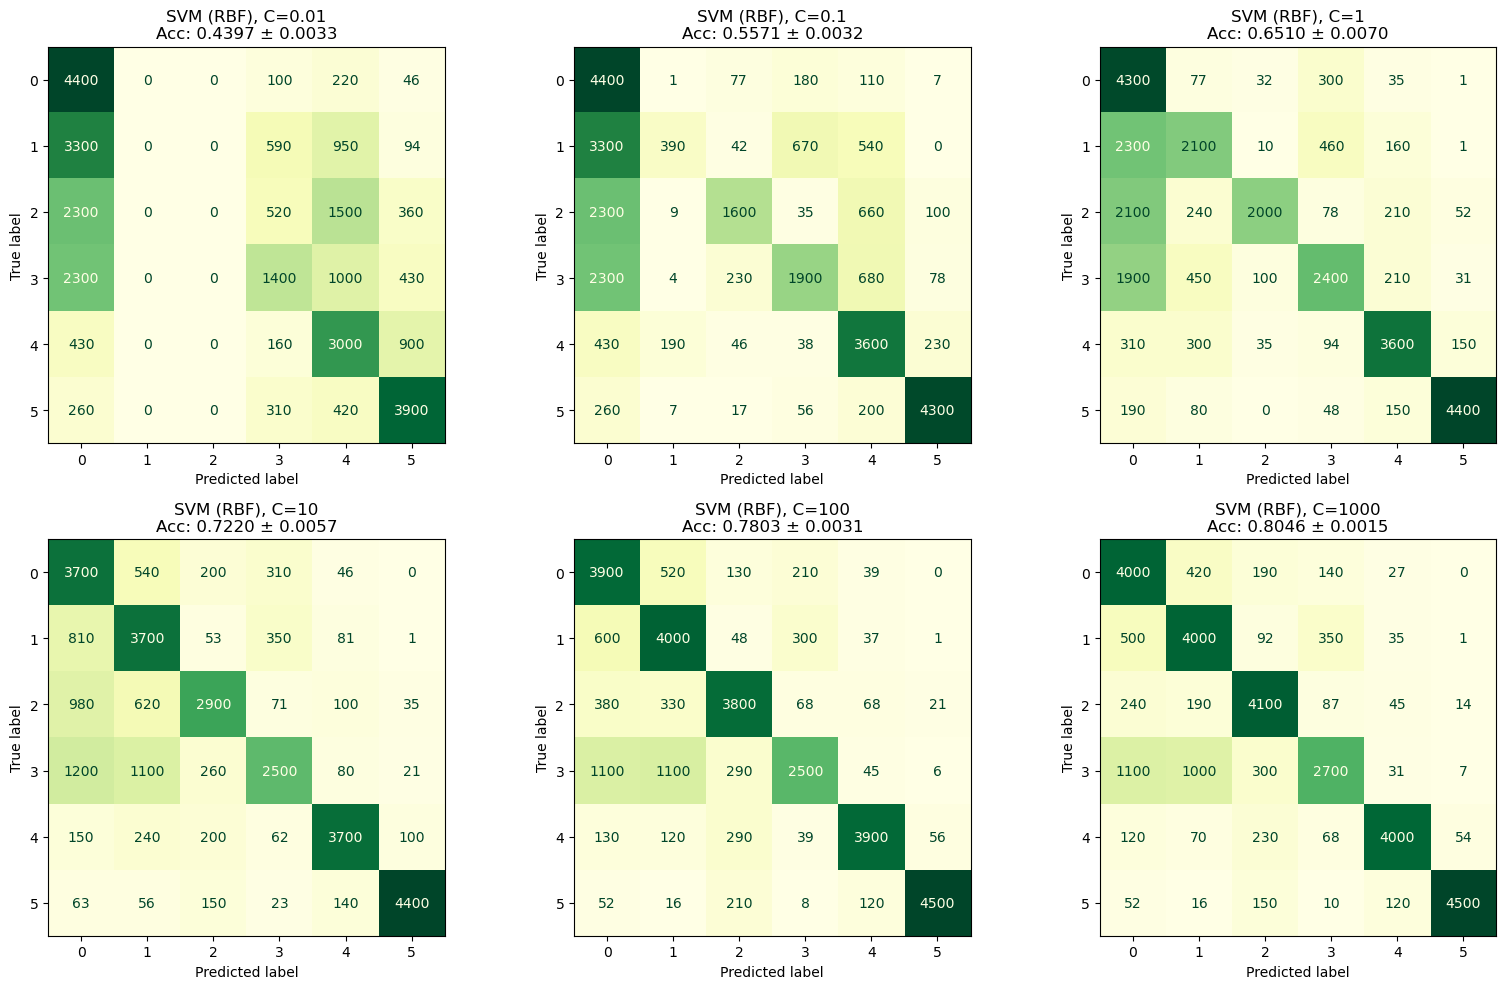

In [16]:
from cuml.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Valores de C a serem testados
C_values = [0.01, 0.1, 1, 10, 100, 1000]

# Configuração do Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plotar as matrizes de confusão em subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # Aumentei o tamanho da figura para 16x10
axes = axes.ravel()

for i, C in enumerate(C_values):
    accuracies = []
    cm_total = np.zeros((6, 6))  # Assumindo 6 classes para combinar as matrizes de confusão

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Criar e treinar o modelo
        model = SVC(C=C, kernel='rbf', gamma='scale')
        model.fit(X_train_fold, y_train_fold)

        # Fazer previsões e avaliar o modelo
        y_pred = model.predict(X_test_fold)
        accuracy = metrics.accuracy_score(y_test_fold, y_pred)
        accuracies.append(accuracy)

        # Atualizar a matriz de confusão acumulada
        cm = metrics.confusion_matrix(y_test_fold, y_pred, labels=[0, 1, 2, 3, 4, 5])
        cm_total += cm

    # Plotar a matriz de confusão acumulada para o valor de C atual
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=["0", "1", "2", "3", "4", "5"])
    disp.plot(cmap="YlGn", ax=axes[i], colorbar=False)

    # Garantir que os números sejam mostrados inteiros (sem notação científica)
    for labels in disp.text_.ravel():
        labels.set_text(f'{int(float(labels.get_text()))}')  # Converter o texto para inteiro

    axes[i].set_title(f"SVM (RBF), C={C}\nAcc: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

# Ajustes finais e exibição do gráfico
plt.tight_layout()
plt.show()

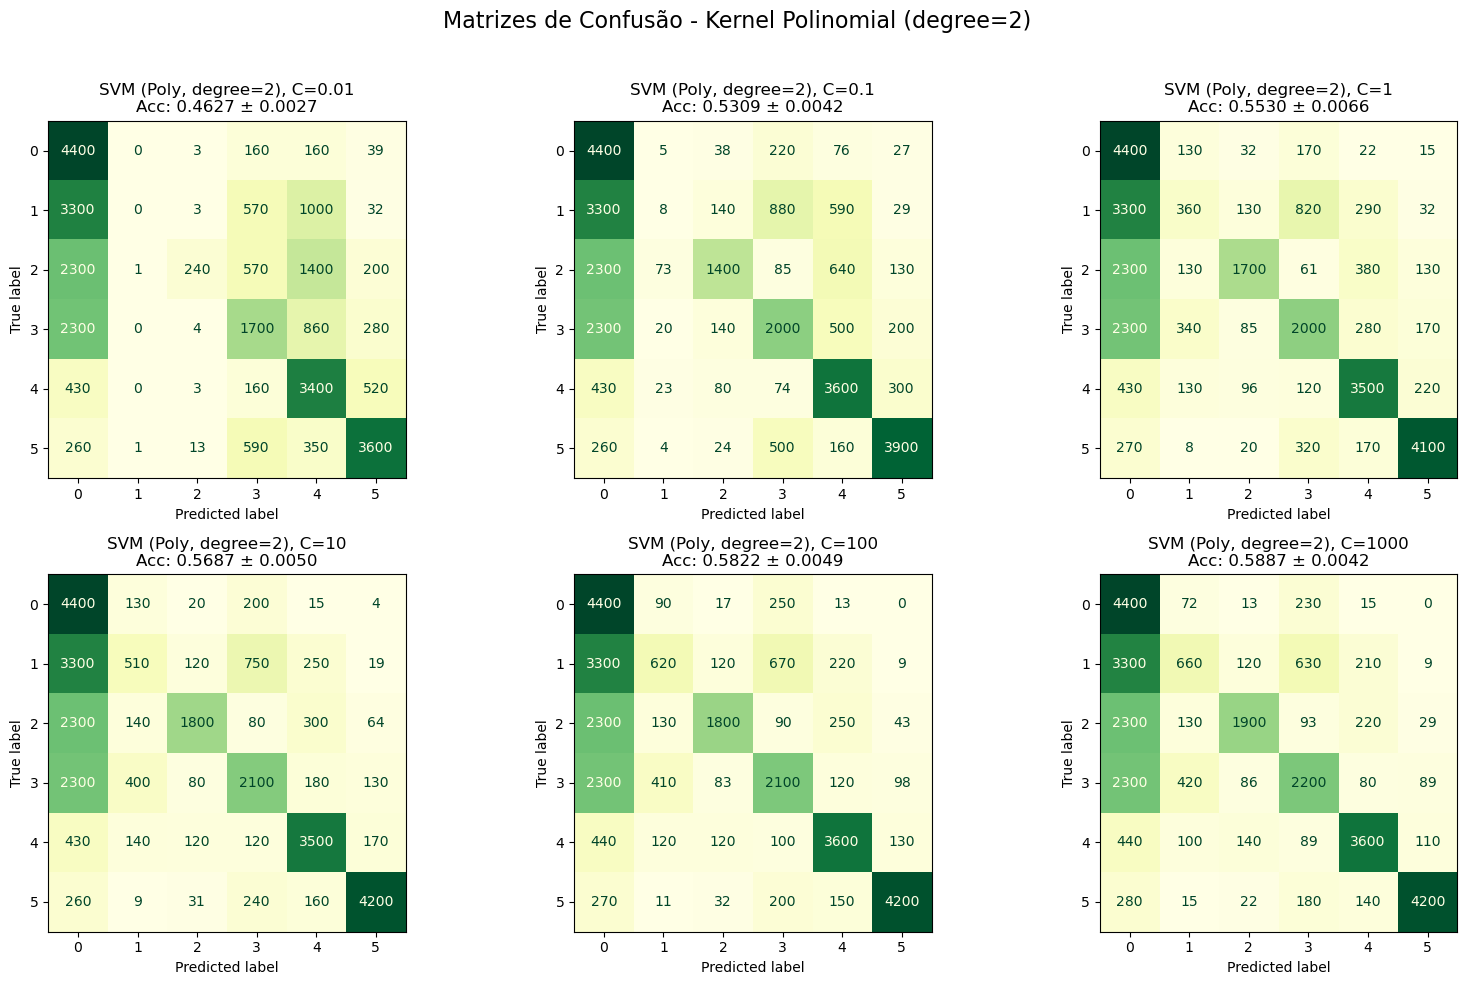

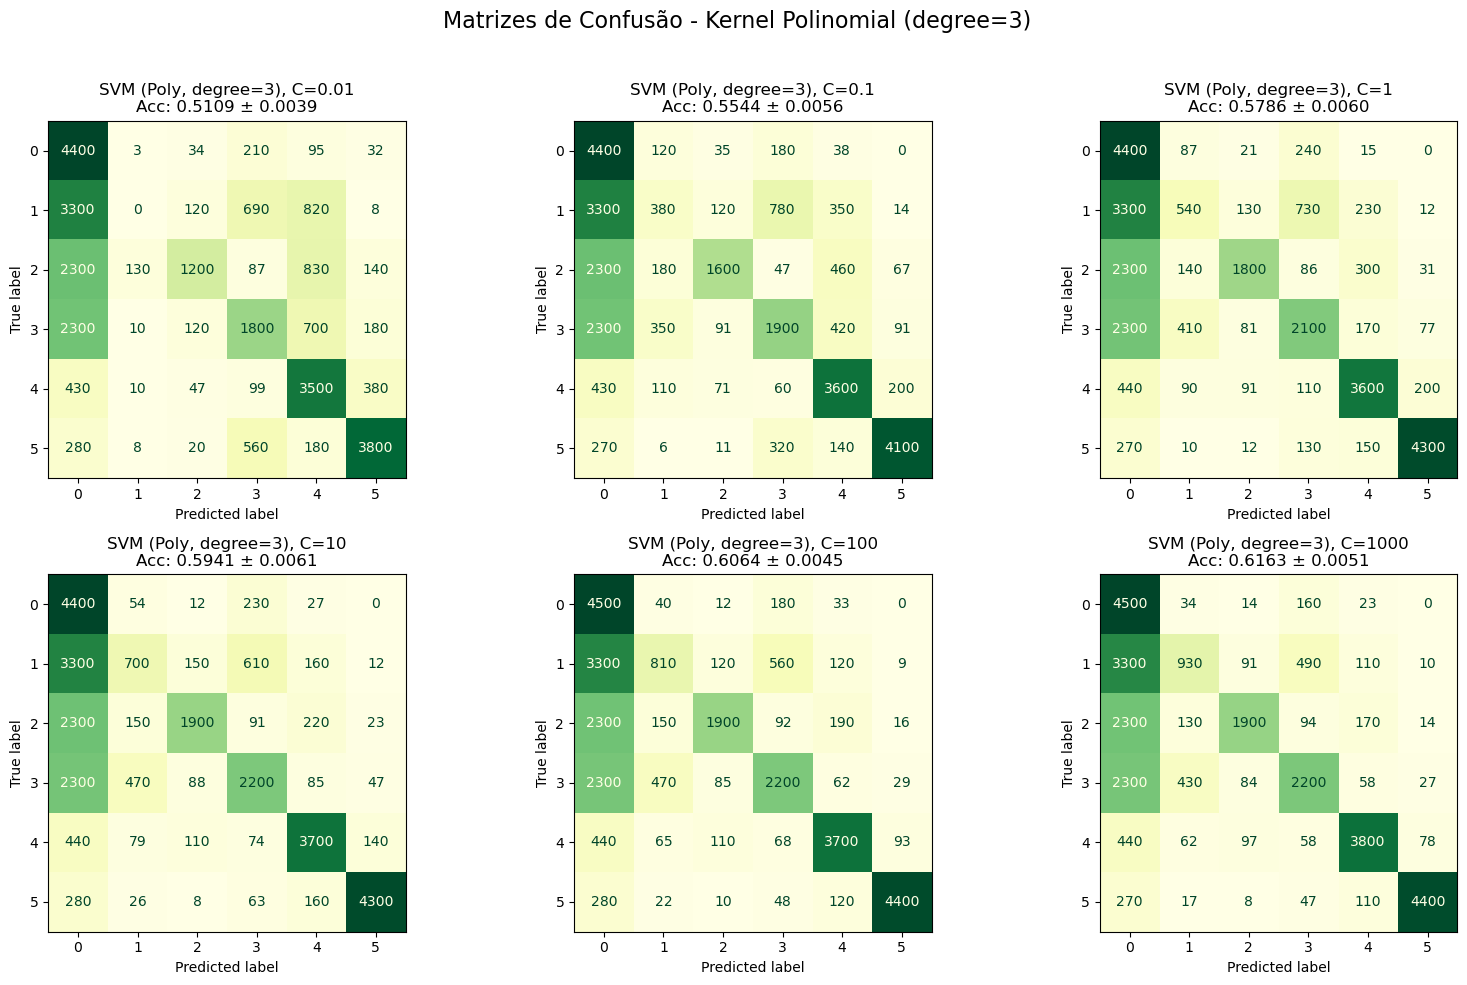

In [17]:
from cuml.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# Graus do polinômio a serem testados
degrees = [2, 3, 4, 5]
# Valores de C a serem testados
C_values = [0.01, 0.1, 1, 10, 100, 1000]

# Configuração do Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterar sobre cada grau do polinômio
for degree in degrees:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # Aumentei o tamanho da figura para 16x10
    axes = axes.ravel()
    
    for i, C in enumerate(C_values):
        accuracies = []
        cm_total = np.zeros((6, 6))  # Assumindo 6 classes para combinar as matrizes de confusão

        for train_index, test_index in skf.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

            # Criar e treinar o modelo
            model = SVC(C=C, kernel='poly', degree=degree, gamma='scale')
            model.fit(X_train_fold, y_train_fold)

            # Fazer previsões e avaliar o modelo
            y_pred = model.predict(X_test_fold)
            accuracy = metrics.accuracy_score(y_test_fold, y_pred)
            accuracies.append(accuracy)

            # Atualizar a matriz de confusão acumulada
            cm = metrics.confusion_matrix(y_test_fold, y_pred, labels=[0, 1, 2, 3, 4, 5])
            cm_total += cm

        # Plotar a matriz de confusão acumulada para o valor de C atual
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=["0", "1", "2", "3", "4", "5"])
        disp.plot(cmap="YlGn", ax=axes[i], colorbar=False)

        # Garantir que os números sejam mostrados inteiros (sem notação científica)
        for labels in disp.text_.ravel():
            labels.set_text(f'{int(float(labels.get_text()))}')  # Converter o texto para inteiro

        axes[i].set_title(f"SVM (Poly, degree={degree}), C={C}\nAcc: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

    # Ajustes finais e exibição do gráfico
    plt.suptitle(f'Matrizes de Confusão - Kernel Polinomial (degree={degree})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar para não sobrepor o título
    plt.show()
